In [7]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import SimpleITK as sitk
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from image_helper import ImageHelper
from roi import ROI
from roi_queue import ROIQueue
import ipywidgets as widgets
from DatasetGenerator import DatasetGenerator
from IPython import display
from stat_helper import *
import time
import pickle

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
n = pickle.load(open('normal.p', 'rb'))
s = pickle.load(open('scaled.p', 'rb'))


[<roi.ROI object at 0x7faabb5a6160>] [<roi.ROI object at 0x7faafc0d9320>]


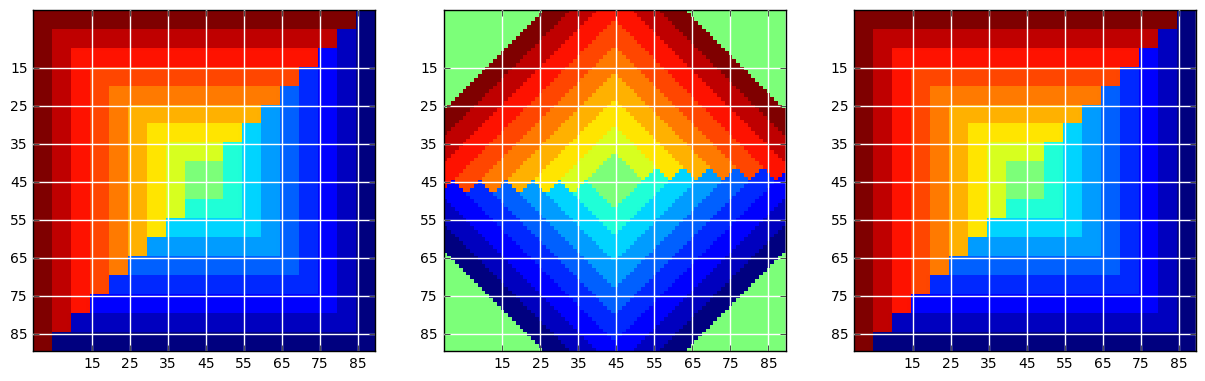

In [5]:
def pad_image(ndarray, target_shape, value) :
    lookup = []
    
    for idx, v in enumerate(target_shape):
        target = target_shape[idx]
        current = ndarray.shape[idx]
        diff = target - current
        if diff < 0:
            raise ValueError("Padding failed, target dimensions is smaller than image dimensions")

        diff_pair = [int(diff / 2), int(diff / 2)]

        # if diff is odd, add one to the "right" side
        if diff % 2 == 1:
            diff_pair[1] += 1

        lookup.append(diff_pair)

    return np.lib.pad(ndarray, lookup, 'constant', constant_values=(value, -value))

image_full_size = 100
image_size = np.array([image_full_size, image_full_size, image_full_size])

x = y = z = 10
cube_size = np.array([x, y, z])
ndarray = np.zeros(cube_size)

center = (image_size / 2)

for i in range(10, image_full_size, 10):
    
    ndarray = pad_image(ndarray, [i, i, i], int(i/10))



f, (ax1, ax2, ax3) = plt.subplots(1, 3)
f.set_size_inches(15, 15)

ax1.set_xticks(range(15,100, 10 ))
ax1.set_yticks(range(15,100, 10 ))
ax1.grid(color='w', linestyle='-', linewidth=1)
ax1.imshow(ndarray[:,:,45], interpolation='none')
import math
rotation = [0, 0, 45]
rotation = np.float32(rotation) * (math.pi/180)

rigid_euler = sitk.Euler3DTransform()

rotation_center = (np.array(ndarray.shape) / 2) - 0.5
rigid_euler.SetCenter(rotation_center)

rigid_euler.SetRotation(float(rotation[0]), float(rotation[1]), float(rotation[2]))
ndarray_2 = np.swapaxes(sitk.GetArrayFromImage(sitk.Resample(
                sitk.GetImageFromArray(np.swapaxes(ndarray, 0, 2)),
                rigid_euler, sitk.sitkNearestNeighbor, 0,sitk.sitkFloat32)),0, 2)

ax2.set_xticks(range(15,100, 10))
ax2.set_yticks(range(15,100, 10))
ax2.grid(color='w', linestyle='-', linewidth=1)
ax2.imshow(ndarray_2[:,:,45], interpolation='none')

rotation_center = (np.array(ndarray.shape) / 2)

rotation = [180, 180, 180]
rotation = np.float32(rotation) * (math.pi/180)
rigid_euler.SetRotation(float(rotation[0]), float(rotation[1]), float(rotation[2]))

ndarray_3 = np.swapaxes(sitk.GetArrayFromImage(sitk.Resample(
                sitk.GetImageFromArray(np.swapaxes(ndarray, 0, 2)),
                rigid_euler, sitk.sitkNearestNeighbor, 0,sitk.sitkFloat32)),0, 2)
ax3.set_xticks(range(15,100, 10))
ax3.set_yticks(range(15,100, 10))
ax3.grid(color='w', linestyle='-', linewidth=1)
ax3.imshow(ndarray_3[:,:,45], interpolation='none')

714740090


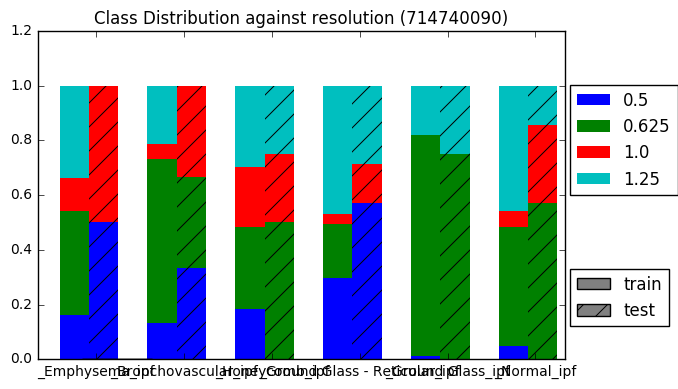

In [150]:
roi_queue = ROIQueue('new_set.p',random_seed=714740090)
data, randseed = roi_queue.get_dataset_resolution_stats()

print(randseed)
res_class_dist(data, randseed)

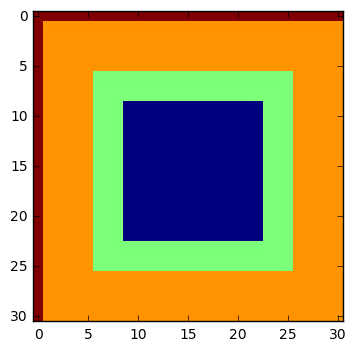

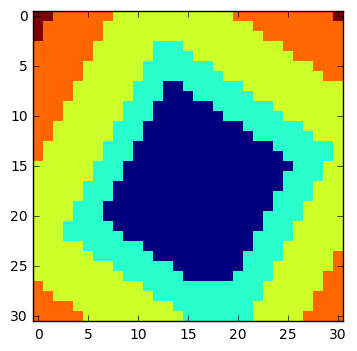

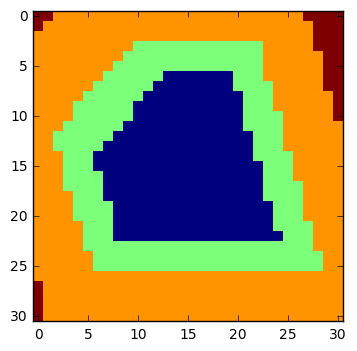

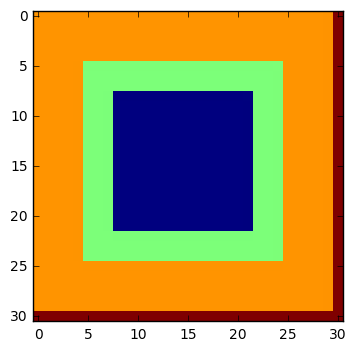

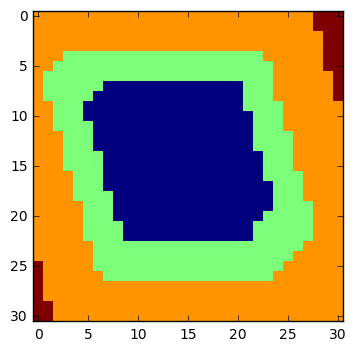

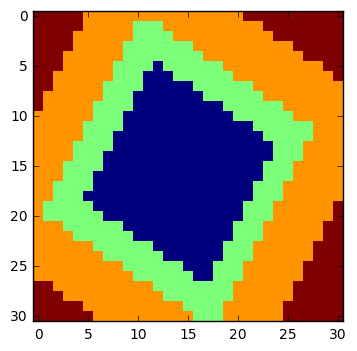

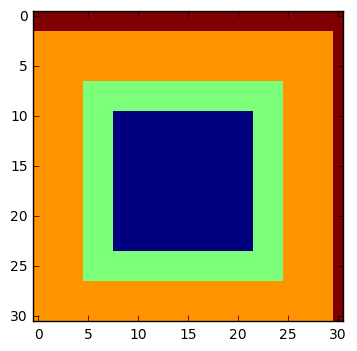

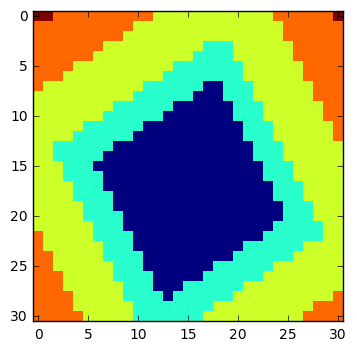

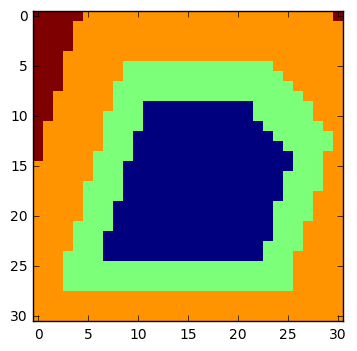

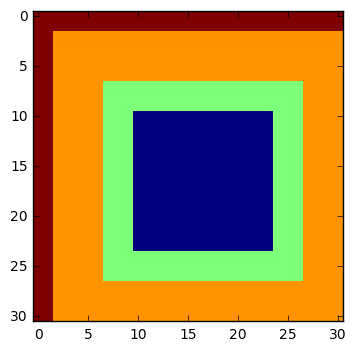

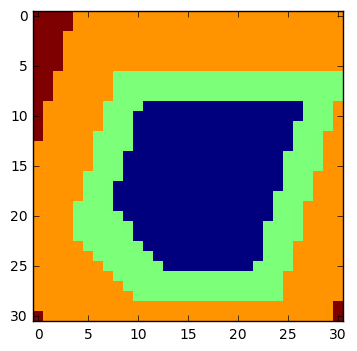

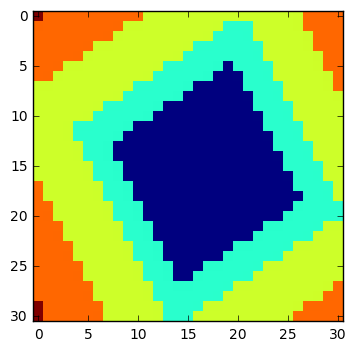

In [6]:
def generate_roi_text(roi_type, center, dimensions) :
    c = []
    d = []
    for i in center: c.append(str(i))
    for i in dimensions: d.append(str(i))
        
    return [
        "1", roi_type, "6", "3,1", "4,0", "5,0", "6,0", "7,0", "8,0", "11",
        ",".join(c), 
        ",".join(d),
        "end"
    ]

def pad_image(ndarray, target_shape, value) :
    lookup = []
    
    for idx, v in enumerate(target_shape):
        target = target_shape[idx]
        current = ndarray.shape[idx]
        diff = target - current
        if diff < 0:
            raise ValueError("Padding failed, target dimensions is smaller than image dimensions")

        diff_pair = [int(diff / 2), int(diff / 2)]

        # if diff is odd, add one to the "right" side
        if diff % 2 == 1:
            diff_pair[1] += 1

        lookup.append(diff_pair)

    return np.lib.pad(ndarray, lookup, 'constant', constant_values=value)

image_full_size = 100
image_size = np.array([image_full_size, image_full_size, image_full_size])

x = y = z = 14
x_1 = y_1 = z_1 = 31

cube_size = np.array([x, y, z])
roi_size = np.array([x_1, y_1, z_1])
ndarray = np.zeros(cube_size)

for i in range(20, image_full_size, 10):
    ndarray = pad_image(ndarray, [i, i, i], int(i/10))

    
center = (np.array(ndarray.shape) / 2) - 0.5

# plt.imshow(ndarray[:,int(image_full_size/2),:], interpolation='none')

im = sitk.GetImageFromArray(np.swapaxes(ndarray, 0, 2))
sitk.WriteImage(im, 'test.nrrd')


roi = ROI('test', generate_roi_text('test', center, roi_size), {})

roi.load_cube(im, padded_size=roi_size)

#plt.imshow(roi.cube[:,8,:], interpolation='none')
sitk.WriteImage(sitk.GetImageFromArray(roi.cube), 'roi.nrrd')
c = roi.get_cube(rotation=(0,0,0), as_nd=False)
sitk.WriteImage(c, 'roi.nrrd')
for a in range(0, 360, 30):
    sub_cube = roi.get_cube(rotation=(0,a,a), as_nd=True)
    fig,ax = plt.subplots(1,1)
    ax.imshow(sub_cube[:,:,15], interpolation='none')
    fig.canvas.draw()


#sitk.WriteImage(sitk.GetImageFromArray(roi.cube), 'roi.nrrd')
#sitk.WriteImage(im, 'test.nrrd')
# sitk.WriteImage(roi.get_cube(rotation=(90, 45, 45), as_nd=False), 'roi.nrrd')


In [ ]:
def show_image_with_rois(img, rois=None, color_lookup=None, title=None, margin=0.05, dpi=80 ):
    
    if rois is None:
        rois = []
        
    nda = sitk.GetArrayFromImage(img)

    spacing = img.GetSpacing()
    ysize = nda.shape[1]
    xsize = nda.shape[2]


    # Make a figure big enough to accomodate an axis of xpixels by ypixels
    # as well as the ticklabels, etc...
    figsize = (1 + margin) * ysize / dpi, (1 + margin) * xsize / dpi
    
    def onclick(event):
        print('button=%d, x=%d, y=%d, xdata=%f, ydata=%f' %
          (event.button, event.x, event.y, event.xdata, event.ydata))

    
    def callback(slc=None):

        display.clear_output(wait=True)
        
        z = nda.shape[0]-1
        if slc is not None:
            z = int(slc['new'])
           
        extent = (0, xsize*spacing[1], ysize*spacing[0], 0)

        fig = plt.figure(figsize=figsize, dpi=dpi)
        fig.canvas.mpl_connect('button_press_event', onclick)

        # Make the axis the right size...
        ax = fig.add_axes([margin, margin, 1 - 2*margin, 1 - 2*margin])

        plt.set_cmap("gray")
        

        rois_in_view = []
        p_list = {}
        for roi in rois:
            if z in range(roi.roi_start_idx[2], roi.roi_end_idx[2]):
                lbl = roi.roi_class.replace('_ipf', '').replace('_', ' ')
                p =  patches.Rectangle(
                    (roi.roi_start_idx[0], roi.roi_start_idx[1]),   # (x,y)
                    roi.roi_size[0], # width
                    roi.roi_size[1], # height
                    fill=False,
                    color=color_lookup[roi.roi_class],
                    label=lbl
                )
                p_list[lbl] = p
                ax.add_patch(p)
        

        ax.imshow(nda[z,...], extent=extent, interpolation=None)

        if title:
            plt.title(title)

        plt.legend(handles=list(p_list.values()))
        plt.show()
        
        
    slider = widgets.IntSlider(
        value=int(nda.shape[0]/2),
        min=0,
        max=nda.shape[0]-1
    )
    slider.observe(callback, names=['value'])
    display.display(slider)
    return slider


def show_image(img, title=None, margin=0.05, dpi=20 ):
    
    nda = sitk.GetArrayFromImage(img)

    spacing = img.GetSpacing()
    ysize = nda.shape[1]
    xsize = nda.shape[2]


    # Make a figure big enough to accomodate an axis of xpixels by ypixels
    # as well as the ticklabels, etc...
    figsize = (1 + margin) * ysize / dpi, (1 + margin) * xsize / dpi
    
    def callback(slc=None):

        display.clear_output(wait=True)
        z = nda.shape[0]-1
        if slc is not None:
            z = int(slc['new'])
           
        extent = (0, xsize*spacing[1], ysize*spacing[0], 0)

        fig = plt.figure(figsize=figsize, dpi=dpi)

        # Make the axis the right size...
        ax = fig.add_axes([margin, margin, 1 - 2*margin, 1 - 2*margin])

        plt.set_cmap("gray")
        
        ax.imshow(nda[z,...], extent=extent, interpolation=None)

        if title:
            plt.title(title)

        plt.show()
        
        
    slider = widgets.IntSlider(
        value=int(nda.shape[0]/2),
        min=0,
        max=nda.shape[0]-1
    )
    slider.observe(callback, names=['value'])
    display.display(slider)
    return slider

In [ ]:
data_path = "./RawData/"
DG = DatasetGenerator(data_path, None, ignore_classes=['_Mix_ipf'])
DG.read_rois()

In [ ]:
colors = ['red', 'green', 'blue', 'yellow', 'cyan', 'magenta', 'white']
color_lookup = dict(zip(list(DG.class_lookup.keys()), colors))
    
cached_images = {}
slice_widget = None

def handle_change(a):

    global slice_widget
    selected_image = a['new']
    
    if selected_image not in cached_images:
        cached_images[selected_image] = DatasetGenerator.read_image_from_pass(data_path + selected_image + '.img.gz')
    

    if slice_widget is not None and slice_widget.close:
        slice_widget.close()
    slice_widget = show_image_with_rois(
        cached_images[selected_image], 
        rois=DG.image_data[selected_image],
        color_lookup=color_lookup,
        title=selected_image, 
        dpi=30
    )
    
input_select = widgets.Select(
    description='Image:',
    options=list(DG.image_data.keys()),
)

input_select.observe(handle_change, names=['value'])

input_select

In [ ]:
for idx in cached_images:
    for roi in DG.image_data[idx]:
        im = roi.getCube(cached_images[idx],rotation=[0, 0, 0], as_nd=False)
        show_image(im, title=roi.roi_class.replace('_ipf', '').replace('_',''))
        break
    break
        #plt.imshow(im)
        # print(im)    



In [ ]:
for idx in cached_images:
    for roi in DG.image_data[idx]:
        im = roi.getCube(cached_images[idx],rotation=[0,0,30], as_nd=False)
        show_image(im, title=roi.roi_class.replace('_ipf', '').replace('_',''))
        #plt.imshow(im)
        # print(im)    
        break
    break



In [ ]:
import pickle
data = pickle.load( open( "test.p", "rb" ) )


def run():
    intersections = 0
    count = 0
    class_dist_non = {}
    class_dist_int = {}
    for idx in data:
        for roi in data[idx]:
            x = roi.get_cube(rotation=None, as_nd=False)
            y = roi.get_cube(rotation=[0, 0, 10], as_nd=False)
        
            count += 1
            if count == 10:
                X, Y=roi.get_set()
                print(X.shape, Y.shape)
                X,Y=roi.get_set(rotation=[0, 0, 10])
                print(X.shape, Y.shape)
                show_image(x)
                show_image(y)
            if roi.has_intersection:
                intersections += 1
                if roi.roi_class not in class_dist_int:
                    class_dist_int[roi.roi_class] = 0
                class_dist_int[roi.roi_class] += 1

            else :
                if roi.roi_class not in class_dist_non:
                    class_dist_non[roi.roi_class] = 0
                class_dist_non[roi.roi_class] += 1
run()

In [41]:
sitk.ScaleTransform?

[autoreload of image_helper failed: Traceback (most recent call last):
  File "/home/mostafa/anaconda3/lib/python3.5/site-packages/IPython/extensions/autoreload.py", line 247, in check
    superreload(m, reload, self.old_objects)
  File "/home/mostafa/Projects/Qual/Code/image_helper.py", line 71
    im_new =
           ^
SyntaxError: invalid syntax
]


In [5]:
def show_single_roi(img_data, roi_data, roi, lbl="Roi", title=None, margin=0.05, dpi=80 ):
    
    nda = None
    spacing = None
    if type(img_data) is np.ndarray:
        nda = img_data
        spacing = [0.7, 0.7]
    else :
        nda = sitk.GetArrayFromImage(img_data)
        spacing = img_data.GetSpacing()
    
    ysize = nda.shape[1]
    xsize = nda.shape[2]
    
    display.clear_output(wait=True)

    z = roi.roi_start_idx[2] + 7

    extent = (0, xsize, ysize, 0)
    fig, ax_arr = plt.subplots(1, 2)
    fig.set_dpi(dpi)
    fig.set_size_inches( 2 * (1 + margin) * ysize / dpi, (1 + margin) * xsize / dpi)
    
    # Make the axis the right size...
    
    #ax = fig.add_axes([margin, margin, 1 - 2*margin, 1 - 2*margin])


    p_list = {}
    p_list[lbl] = patches.Rectangle(
        (roi.roi_start_idx[0], roi.roi_start_idx[1]),   # (x,y)
        15, # width
        15, # height
        fill=False,
        color='red',
        label=roi.roi_class.replace('_ipf', '').replace('_', ' ')
    )
    ax_arr[0].add_patch(p_list[lbl])
    ax_arr[0].imshow(nda[z,...], cmap="gray", extent=extent, interpolation=None)
    ax_arr[1].imshow(roi_data, interpolation='none', cmap="gray")
    ax_arr[0].legend(handles=list(p_list.values()))
    
    plt.title(roi.image_id)
    plt.show()
    # print("Reported Center " + str(roi.roi_center) )
    # print("Start Index" + str(roi.roi_start_idx) )
    # print("End Index" + str(roi.roi_end_idx) )
    
    # print(roi_data.shape)
    # print(np.max(roi_data))
    # print("X:")
    # for i in range(15):
    #    print(roi_data[:,i])
    
    # print("Y:")
    # for i in range(15):
    #    print(roi_data[i,:])
    
    

In [6]:
import random

def cycle_roi(data_filename):
    loaded_images = {}
    roi_queue = ROIQueue(data_filename, batch_size=32, train_angles=[0], test_angles=[0], validate_angles=[0])
    with roi_queue as roi_generator:
        next(roi_generator)
        while True:

            display.clear_output(wait=True)
            X, Y, roi, rotation = roi_generator.send(('train', 1, False))
            X = np.squeeze(X['image'][0])
            rotation = rotation[0]
            roi = roi[0]
            if roi.image_id not in loaded_images:
                img_path = './RawData/{0}.img.gz'.format(roi.image_id)
                spacing_factor, image = ImageHelper.read_image(img_path, correct_spacing=True)
                loaded_images[roi.image_id] = image
                
            X = X[:,:,7]
            
            show_single_roi(loaded_images[roi.image_id], X, roi)
            yield

gen = cycle_roi('normal.p')
def on_next_clicked(btn):
    next(gen)


    
btn_next = widgets.Button(description='Next Example')
btn_next.on_click(on_next_clicked)
display.display(btn_next)     



TypeError: 'NoneType' object is not iterable